# Milestone 3 - Deep Learning

Aman Gupta, Aryan Bhardwaj, Liza George, Justin Kim

# Final Model

In this stage we used our learnings from the data exploration last week to build a deep learning model that predicts end station based on the following input features:
- ride type (classic vs electric bike)
- rider type (member vs casual rider)
- start region
- ride start hour of the day
- ride start day of the month
- ride start month of the year
- ride start day of the week
- weather of the day

We decided to examine the ride's start and end region (NYC neighborhood) instead of exact station becayse there were too many unique stations (474) to use directly in predictions.

The model is a fusion of a standard neural network and a graph neural network, where start and end station regions where the nodes in the graph.

## Import and preprocess data

### Import Relevant Packages

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
import math

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Use GPU for faster computations

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if __name__=='__main__':
    print('Using device:', DEVICE)

Using device: cuda



### Open Pickled Data

This is from what we extracted and pickled in Milestone 1 (updated to our [data extraction Notebook](https://colab.research.google.com/drive/1BInmWkNqitlIHXVlWWTid3fwA4y96J5j?usp=sharing)).

In [ ]:
# NOTE FOR GRADERS - please add the folder linked below to your drive and alter this string to match the location of the "pickled_data" folder:
# https://drive.google.com/drive/folders/1upZ3Oh242b83WTBUQB4HS64M0BlY2PHE?usp=drive_link
shared_folder_path = f'/content/drive/MyDrive/CS547 Project Group 11/pickled_data'
save_path = f'{shared_folder_path}/working_dataset_2023.pkl'

In [ ]:
df = pd.read_pickle(save_path)
df = df.sample(frac=0.5).reset_index(drop=True)
print(df.shape)

(8776757, 13)


In [ ]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,D4A14D8E1F6B1937,classic_bike,2023-02-15 13:24:19.223,2023-02-15 13:28:48.001,Kosciuszko St & Nostrand Ave,4519.04,Putnam Ave & Nostrand Ave,4327.09,40.690725,-73.951335,40.684020,-73.949770,member
1,E09948898C7E48FD,electric_bike,2023-10-18 18:35:37.087,2023-10-18 18:38:00.418,Carmine St & 6 Ave,5763.03,Carmine St & 6 Ave,5763.03,40.730386,-74.002150,40.730386,-74.002150,member
2,EFAEB18288A3CFDA,classic_bike,2023-03-09 07:48:39.009,2023-03-09 07:51:20.463,E 67 St & Park Ave,6932.14,E 59 St & Madison Ave,6801.01,40.767801,-73.965921,40.763505,-73.971092,casual
3,0968DF3B2CB020FC,classic_bike,2023-07-07 10:56:41.532,2023-07-07 11:01:08.363,W 25 St & 6 Ave,6215.04,W 15 St & 6 Ave,5989.02,40.743954,-73.991449,40.738046,-73.996430,member
4,B3357BEC0712B6A5,classic_bike,2023-09-10 11:50:00.211,2023-09-10 11:54:48.737,W 13 St & 7 Ave,6030.04,Washington Pl & 6 Ave,5838.09,40.737815,-73.999947,40.732241,-74.000264,member


In [ ]:
# Process Weather Data
weather_df = pd.read_csv(f'{shared_folder_path}/weather_data.csv')
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

weather_df['start_day'] = weather_df['DATE'].dt.day
weather_df['start_month'] = weather_df['DATE'].dt.month
weather_df.drop(columns=['STATION', 'NAME', 'DATE'], inplace=True)
weather_df.head()

,PRCP,SNOW,SNWD,WESD,WESF,start_day,start_month
0,0.40,0.0,0.0,0.0,0.0,1,1
1,0.00,0.0,0.0,0.0,0.0,2,1
2,0.02,0.0,0.0,0.0,0.0,3,1
3,0.37,0.0,0.0,0.0,0.0,4,1
4,0.09,0.0,0.0,0.0,0.0,5,1


### Mapping features to integers as needed

In [ ]:
# Region coordinates derived from ChatGPT

REGION_MAPPING = {
    "Lower Manhattan": 0,
    "Midtown": 1,
    "Upper East Side": 2,
    "Upper West Side": 3,
    "East Village": 4,
    "West Village": 5,
    "Chelsea": 6,
    "Harlem": 7,
    "Downtown Brooklyn": 8,
    "North Brooklyn": 9
}
REGION_LOCS = {
    0: (40.7128, -74.0060),
    1: (40.7549, -73.9840),
    2: (40.7736, -73.9566),
    3: (40.7870, -73.9754),
    4: (40.7264, -73.9818),
    5: (40.7347, -74.0049),
    6: (40.7430, -74.0018),
    7: (40.8116, -73.9465),
    8: (40.6958, -73.9936),
    9: (40.7081, -73.9571)
}

In [ ]:
import numpy as np

# Convert REGION_LOCS to a NumPy array for efficient computation
region_ids = np.array(list(REGION_LOCS.keys()))
region_coords = np.array(list(REGION_LOCS.values()))

def vectorized_haversine(lat, lon, region_coords):
    """Vectorized calculation of haversine distance between points and regions."""
    R = 6371  # Earth's radius in km

    # Convert degrees to radians
    lat1, lon1 = np.radians(lat), np.radians(lon)
    region_lat, region_lon = np.radians(region_coords[:, 0]), np.radians(region_coords[:, 1])

    # Calculate haversine formula
    dlat = region_lat[:, None] - lat1
    dlon = region_lon[:, None] - lon1
    a = np.sin(dlat / 2)**2 + np.cos(region_lat[:, None]) * np.cos(lat1) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # Distance in kilometers

# Vectorized function to find nearest region
def find_nearest_regions(latitudes, longitudes, region_coords, region_ids):
    distances = vectorized_haversine(latitudes, longitudes, region_coords)
    nearest_indices = np.argmin(distances, axis=0)
    return region_ids[nearest_indices]

# Apply the vectorized function to the DataFrame
df['start_region'] = find_nearest_regions(df['start_lat'].values, df['start_lng'].values, region_coords, region_ids)
df['end_region'] = find_nearest_regions(df['end_lat'].values, df['end_lng'].values, region_coords, region_ids)

In [ ]:
# Encode 'rideable_type' and store the mapping
df['rideable_type'], rideable_type_mapping = pd.factorize(df['rideable_type'])
rideable_type_mapping = dict(enumerate(rideable_type_mapping))

In [ ]:
# Encode 'member_casual' and store the mapping
df['member_casual'], member_casual_mapping = pd.factorize(df['member_casual'])
member_casual_mapping = dict(enumerate(member_casual_mapping))

In [ ]:
# Encoding 'started_at' time into different types
df['start_hour'] = df['started_at'].dt.hour
df['start_day'] = df['started_at'].dt.day
df['start_month'] = df['started_at'].dt.month
df['start_weekday'] = df['started_at'].dt.weekday

In [ ]:
# Add weather data
df = df.merge(weather_df, left_on=['start_day', 'start_month'], right_on=['start_day', 'start_month'], how='left')

### Calculate Edge Distances for GNN graph encoding

In [ ]:
# Haversine distance calculation derived from ChatGPT

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Calculate the great circle distance between two points on the earth."""
    R = 6371  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

In [ ]:
# Create Edges for GNN graph
edges = []
for region_name, (region_lat, region_lon) in REGION_LOCS.items():
    for other_region_name, (other_region_lat, other_region_lon) in REGION_LOCS.items():
        distance = haversine_distance(region_lat, region_lon, other_region_lat, other_region_lon)
        edges.append((region_name, other_region_name, distance))

In [ ]:
edges_df = pd.DataFrame(edges, columns=['Region 1', 'Region 2', 'Distance'])
edges_df.head()

,Region 1,Region 2,Distance
0,0,0,0.000000
1,0,1,5.034951
2,0,2,7.938928
3,0,3,8.643947
4,0,4,2.538970


### Isolate Features and Labels

In [ ]:
df.drop(columns=['ride_id', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], inplace=True)

# We exclusively use regions instead of lat/lng for more straightforward relationships between features and label
df.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)
df.dropna(inplace=True)
df.head()

,rideable_type,member_casual,start_region,end_region,start_hour,start_day,start_month,start_weekday,PRCP,SNOW,SNWD,WESD,WESF
0,0,0,9,9,13,15,2,2,0.00,0.0,0.0,0.0,0.0
1,1,0,5,5,18,18,10,2,0.00,0.0,0.0,0.0,0.0
2,0,1,2,1,7,9,3,3,0.00,0.0,0.0,0.0,0.0
3,0,0,6,6,10,7,7,4,0.00,0.0,0.0,0.0,0.0
4,0,0,5,5,11,10,9,6,0.35,0.0,0.0,0.0,0.0


In [ ]:
# Verify the new encoding
num_classes = len(df['end_region'].unique())
print(f"Number of classes after encoding: {num_classes}")
print(f"Maximum class index after encoding: {df['end_region'].max()}")

Number of classes after encoding: 10
Maximum class index after encoding: 9


In [ ]:
# Separate features and target
features = df.drop(columns=['end_region'])
labels = df['end_region']
del df # Deleting unnecessary objects to save RAM

In [ ]:
features.head()

,rideable_type,member_casual,start_region,start_hour,start_day,start_month,start_weekday,PRCP,SNOW,SNWD,WESD,WESF
0,0,0,9,13,15,2,2,0.00,0.0,0.0,0.0,0.0
1,1,0,5,18,18,10,2,0.00,0.0,0.0,0.0,0.0
2,0,1,2,7,9,3,3,0.00,0.0,0.0,0.0,0.0
3,0,0,6,10,7,7,4,0.00,0.0,0.0,0.0,0.0
4,0,0,5,11,10,9,6,0.35,0.0,0.0,0.0,0.0


In [ ]:
labels.head()

,end_region
0,9
1,5
2,1
3,6
4,5


In [ ]:
# Split training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32, device=DEVICE)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=DEVICE)
y_train = torch.tensor(y_train.values, dtype=torch.long, device=DEVICE)
y_test = torch.tensor(y_test.values, dtype=torch.long, device=DEVICE)

## GNN + NN Fusion Model Code

In [ ]:
# Edges for Graph
edge_index = torch.tensor(edges_df[['Region 1', 'Region 2']].values, dtype=torch.long, device=DEVICE).t().contiguous()
edge_weights = torch.tensor(edges_df['Distance'].values, dtype=torch.float32, device=DEVICE)
edge_weights.shape

torch.Size([100])

In [ ]:
# Nodes for graph
node_features = []
for key in range(10):
  (r1, r2) = REGION_LOCS[key]
  node_features.append([key, r1, r2]) # (label, latitude, longitude)

node_features = torch.tensor(node_features, dtype=torch.float32, device=DEVICE)
node_features.shape

torch.Size([10, 3])

In [ ]:
# Create a list of Data objects for each batch of trips
batch_size = 8192
batched_data = []

# Chunk trips and labels into batches
num_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size > 0 else 0)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(X_train))

    # Create a Data object for this batch
    batch_trips = X_train[start_idx:end_idx]
    batch_labels = y_train[start_idx:end_idx]
    batch_data = Data(nodes=node_features,
                      trips=batch_trips,
                      edge_index=edge_index,
                      edge_attr=edge_weights,
                      labels=batch_labels)
    batched_data.append(batch_data)

# Create a DataLoader to manage the batched data
dataloader = DataLoader(batched_data, batch_size=1, shuffle=True)

In [ ]:
class HybridGCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_trip_features, num_nodes):
        super(HybridGCNModel, self).__init__()
        # GCN Layers
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)

        # MLP Layers for the trip features
        self.fc1 = torch.nn.Linear(num_trip_features, 128)
        self.fc2 = nn.Linear(128, 32) # Align dimensions with GCN output

        # Final classifier layers
        self.fc3 = torch.nn.Linear(48, 32)
        self.fc4 = torch.nn.Linear(32, num_nodes)

    def forward(self, data):
        x, edge_index, edge_weights, t = data.nodes, data.edge_index, data.edge_attr, data.trips

        # GCN part: Graph-based learning
        gnn_out = F.relu(self.conv1(x, edge_index=edge_index, edge_weight=edge_weights))
        gnn_out = self.conv2(gnn_out, edge_index=edge_index, edge_weight=edge_weights)

        # apply graph to trip based on start station
        start_station_embeddings = gnn_out[t[:, 2].long()]

        # MLP part: Learning from trip features
        mlp_out = F.relu(self.fc1(t))
        mlp_out = self.fc2(mlp_out)  # Align with GCN output dimension

        # Combine GCN and MLP outputs (concatenation)
        combined_out = torch.cat([start_station_embeddings, mlp_out], dim=1)

        # Final classification
        out = F.relu(self.fc3(combined_out))
        out = self.fc4(out)
        output = F.log_softmax(out, dim=1)

        return output

## Model Training

In [ ]:
# Model Initialization
num_node_features = 3  # Number of node features
num_trip_features = 12  # Number of trip features
num_nodes = 10  # Number of nodes in the graph

model = HybridGCNModel(num_node_features, num_trip_features, num_nodes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(DEVICE)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    tot_loss = 0.0
    optimizer.zero_grad()

    for i, batch in enumerate(dataloader):
      batch = batch.to(DEVICE)

      out = model(batch)  # Forward pass (graph-based and feature-based)
      loss = criterion(out, batch.labels)  # Compute loss
      loss.backward()  # Backpropagate

      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
      optimizer.step()  # Update weights
      optimizer.zero_grad()

      tot_loss += loss.item()

    loss = tot_loss / len(dataloader)
    if epoch % 10 == 0: print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

print(f'Final Loss: {loss:.4f}')

Epoch [1/50], Loss: 1.4962
Epoch [11/50], Loss: 1.3730
Epoch [21/50], Loss: 1.3705
Epoch [31/50], Loss: 1.3696
Epoch [41/50], Loss: 1.3689
Final Loss: 1.3689


In [ ]:
# Evaluation (on test set)
model.eval()
test_data = Data(nodes=node_features,
            trips=X_test,
            edge_index=edge_index,
            edge_attr=edge_weights,
            labels=y_test)
with torch.no_grad():
    out = model(test_data)  # Forward pass on test set
    _, pred = torch.max(out, dim=1)  # Get the predicted classes
    accuracy = (pred == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5548


Our model yielded a final of **0.5548**. This is to be expected after examining our Data Exploration work - while there were slight relationships between the input features and end_regions, none were strong enough to suggest that one could reliably predict the end_region from start_region, weather, time, etc.

Below is an explanation of all the variations to the model that we explored to try and improve the model:

# Exploring different training strategies

## Effects of mini-batch learning (Do not run)

We tried the same model without mini-batch learning with the following code, but it ran out of RAM:

In [ ]:
# Create a PyTorch Geometric Data object
data = Data(nodes=node_features,
            trips=X_train,
            edge_index=edge_index,
            edge_attr=edge_weights,
            labels=y_train)

In [ ]:
# Model Initialization
num_node_features = 3  # Number of node features
num_trip_features = 7  # Number of trip features
num_nodes = 10  # Number of nodes in the graph

model = HybridGCNModel(num_node_features, num_trip_features, num_nodes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(DEVICE)

# Training Loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass (graph-based and feature-based)
    loss = criterion(out, data.labels)  # Compute loss
    loss.backward()  # Backpropagate

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # Gradient clipping

    optimizer.step()  # Update weights

    if epoch % 50 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Final Loss: {loss.item():.4f}')

With a smaller debugging dataset, the result was the model repeatedly converges to the similar loss values and final accuracy value. Thus we stuck to batch learning.

We also tried different types of layers such as GATConv, Conv, and RNN. Each gave very similar losses/accuracies with worse memory results.

## Effects of different optimizers

We tried SGD and the Adam optimizer. Both optimizers yielded similar results.

## Effects of different hyperparameters

We examined the result of using greater numbers of epochs to train with our debugging dataset. As can be seen in the graph below, for the initial 0-50 epochs, there was a sharp decrease in loss and stabilized at around 1.8-1.9 loss. Then from 50-150 epochs there were some minor oscillations in the loss but overall, a slow decrease. From 150-300, the loss remained very stable with slight fluctuations which might be a result of overfitting. Thus we trained with 300 epochs (there is no point in training further than that).

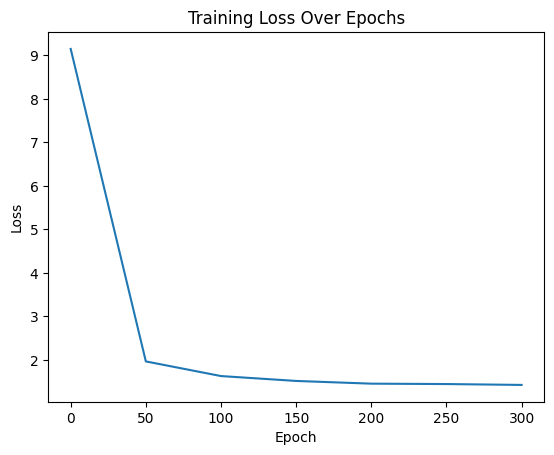

We examined the effect of using different learning rates with our debugging dataset for 300 epochs. The results graphed below show that the learning rate we used (0.01) was optimal

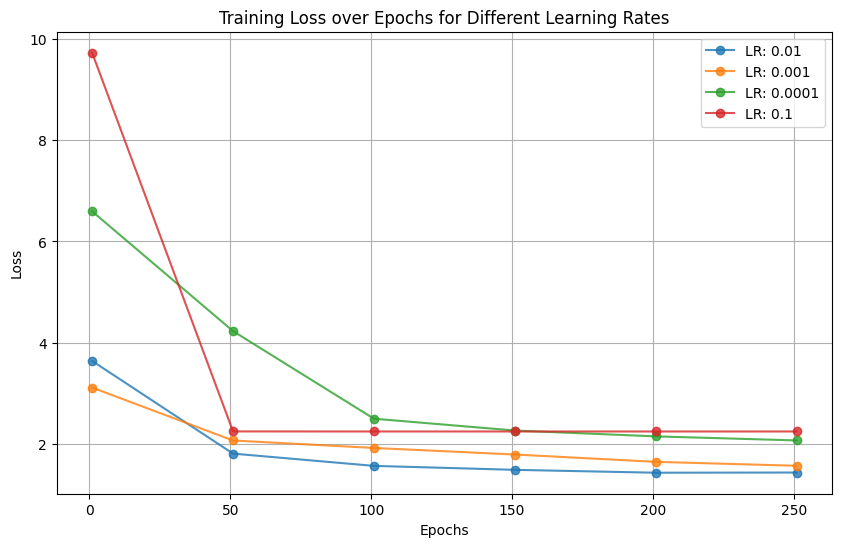

We tried our model with dropout layers with varying dropout rates. But since our model is not overfitting to our training data, dropout only slightly negatively impacted our final performance. Thus we removed those layers.

## Trying normal neural network for training
We tried a simpler model without a GNN on our debugging dataset. The end results were similar to the model above.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import pickle
import pandas as pd

# NOTE FOR GRADERS - please add the folder linked below to your drive and alter this string to match the location of the "pickled_data" folder:
# https://drive.google.com/drive/folders/1upZ3Oh242b83WTBUQB4HS64M0BlY2PHE?usp=drive_link
shared_folder_path = f'/content/drive/MyDrive/CS547 Project Group 11/pickled_data'
save_path = f'{shared_folder_path}/debugging_dataset_2023.pkl'

In [ ]:
debugging_df = pd.read_pickle(save_path)
debugging_df = debugging_df.drop(columns=['start_station_id', 'end_station_id', 'ride_id'])
debugging_df

### Import weather data per date

In [ ]:
weather_path = f'{shared_folder_path}/weather_data.csv'
weather_df = pd.read_csv(weather_path)
weather_df['date'] = pd.to_datetime(weather_df['DATE'])

In [ ]:
weather_df = weather_df.drop(columns=['STATION', 'NAME', 'DATE'])
weather_df = weather_df.fillna(weather_df.mean())
weather_df

### Encode the categorical data using one hot **encoding**

In [ ]:
# Encode 'rideable_type' and store the mapping
debugging_df['rideable_type'], rideable_type_mapping = pd.factorize(debugging_df['rideable_type'])
rideable_type_mapping = dict(enumerate(rideable_type_mapping))

# Encode 'member_casual' and store the mapping
debugging_df['member_casual'], member_casual_mapping = pd.factorize(debugging_df['member_casual'])
member_casual_mapping = dict(enumerate(member_casual_mapping))

# Combine unique values for consistent encoding
unique_regions = pd.unique(debugging_df[['start_region', 'end_region']].values.ravel())
region_mapping = {region: code for code, region in enumerate(unique_regions)}

# Map the codes using the consistent mapping
debugging_df['start_region_ID'] = debugging_df['start_region'].map(region_mapping)
debugging_df['end_region_ID'] = debugging_df['end_region'].map(region_mapping)

# Similarly for start_station_name and end_station_name
unique_stations = pd.unique(debugging_df[['start_station_name', 'end_station_name']].values.ravel())
station_mapping = {station: code for code, station in enumerate(unique_stations)}

# Map the codes using the consistent mapping
debugging_df['start_station_ID'] = debugging_df['start_station_name'].map(station_mapping)
debugging_df['end_station_name_ID'] = debugging_df['end_station_name'].map(station_mapping)

### Getting more features for the date

In [ ]:
debugging_df['date'] = pd.to_datetime(debugging_df['started_at']).dt.date
debugging_df['date'] = pd.to_datetime(debugging_df['date'])
debugging_df['start_hour'] = debugging_df['started_at'].dt.hour
debugging_df['start_day'] = debugging_df['started_at'].dt.day
debugging_df['start_month'] = debugging_df['started_at'].dt.month
debugging_df['start_weekday'] = debugging_df['started_at'].dt.weekday

In [ ]:
# Convert 'date' columns to datetime in both DataFrames
debugging_df['date'] = pd.to_datetime(debugging_df['date'], errors='coerce')
weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

# Verify the date columns
print(debugging_df['date'].head())
print(weather_df['date'].head())

### Joining the data with the weather data on date

In [ ]:
debugging_df = pd.merge(debugging_df, weather_df, on='date', how='left')

In [ ]:
debugging_df.drop(columns=['start_station_name', 'end_station_name', 'start_region', 'end_region', 'ended_at', 'end_lat', 'end_lng', 'end_station_name_ID', 'started_at', 'date'], inplace=True)

### Normalize the longitude and latitude

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ["start_lat", "start_lng"]
debugging_df[numerical_features] = scaler.fit_transform(debugging_df[numerical_features])

### Predict the end region

In [ ]:
label_name = 'end_region_ID'

In [ ]:
# Verify the new encoding
num_classes = len(debugging_df[label_name].unique())
print(f"Number of classes after encoding: {num_classes}")
print(f"Maximum class index after encoding: {debugging_df[label_name].max()}")

In [ ]:
# Create and fit the label encoder
label_encoder = LabelEncoder()
debugging_df[label_name] = label_encoder.fit_transform(debugging_df[label_name])

In [ ]:
# Separate features and target
features = debugging_df.drop(columns=[label_name])
target = debugging_df[label_name]

### Create train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32, device=DEVICE)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=DEVICE)
y_train = torch.tensor(y_train.values, dtype=torch.long, device=DEVICE)
y_test = torch.tensor(y_test.values, dtype=torch.long, device=DEVICE)

### Remove NaN values for training

In [ ]:
# Check for NaN or infinite values in the input data
print(torch.isnan(X_train).any())
print(torch.isinf(X_train).any())
print(torch.isnan(y_train).any())
print(torch.isinf(y_train).any())

# If any NaN or inf values are present, you can remove or replace them
X_train = X_train[~torch.isnan(X_train).any(dim=1)]
y_train = y_train[~torch.isnan(y_train)]


In [ ]:
class RidePredictionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(RidePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Define model
input_dim = X_train.shape[1]
num_classes = len(debugging_df[label_name].unique())
model = RidePredictionModel(input_dim, num_classes)
model.to(DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt

# Initialize a list to store loss values
loss_values = []

# Training loop
num_epochs = 40
batch_size = 512

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    permutation = torch.randperm(X_train.size(0))

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Store the average loss for this epoch
    average_loss = epoch_loss / (X_train.size(0) // batch_size)
    loss_values.append(average_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

In [ ]:
# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    predicted_classes = torch.argmax(y_pred, axis=1)
    accuracy = (predicted_classes == y_test).float().mean()

print(f"Test Accuracy: {accuracy:.4f}")

# Sources
- Course slides and example code for Feed Forward Neural Nets
- [Explanation of Graph Neural Networks](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/06-graph-neural-networks.html#)
- ChatGPT and Perplexity to generate some utility code snippets (cited where used)


https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/06-graph-neural-networks.html#